<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Test_JAX_FLows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q distrax dm-haiku optax


     |████████████████████████████████| 272 kB 8.3 MB/s 
     |████████████████████████████████| 350 kB 58.8 MB/s 
     |████████████████████████████████| 145 kB 85.2 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16
from mpl_toolkits.axes_grid1 import make_axes_locatable


from typing import Any, Mapping, Sequence, Tuple

import distrax
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from distrax._src.bijectors.bijector import Array
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [3]:
print(tfp.__version__, distrax.__version__, optax.__version__, hk.__version__)

0.16.0 0.1.2 0.1.3 0.0.8


In [4]:
#avoid boring Warnings
import logging
logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())


In [118]:
Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any

MODEL = 'MAF' # 
TARGET_DENSITY = 'Energy_3' # {'Banana', 'Energy_1', 'Energy_3','Gauss_blobs' } Which dataset to model. 

if MODEL == 'NVP':
    FLOW_NUM_LAYERS= 6
    HIDDEN_SIZE= 128
    MLP_NUM_LAYERS= 2

elif MODEL == 'MAF':
  FLOW_NUM_LAYERS = 8
  HIDDEN_SIZE = 64
  MLP_NUM_LAYERS = 2
  FLOW_NUM_PARAMS = 12  




In [108]:
def make_dataset_banana(seed: int, batch_size: int = 8, num_batches: int = 1):
    """pdf(x1,x2)=N(x1|(1/4)*x2**2,1)N(x2|0,4)"""

    prng_seq = jax.random.PRNGKey(seed)
    for _ in range(num_batches):
        key, subkey = jax.random.split(prng_seq, num=2)
        x2 = tfd.Normal(loc=0, scale=2.).sample(
            seed=key, sample_shape=batch_size
        )
        x1 = tfd.Normal(loc=x2 ** 2 / 4, scale=1.).sample(seed=subkey)
        yield jnp.stack([x1, x2], axis=-1)


def make_dataset_energy_1(seed: int, batch_size: int = 8, num_batches: int = 1):
    prng_seq = hk.PRNGSequence(seed)

    def loc(z):
        mu = 2 - z ** 2 / 32
        return jnp.stack([mu, -mu], axis=-1)

    for _ in range(num_batches):
        key = next(prng_seq)
        dist = tfd.JointDistributionSequential(
            [
                tfd.Normal(loc=0, scale=2),
                lambda mu: tfd.MixtureSameFamily(
                    tfd.Categorical(probs=[0.5, 0.5]),
                    tfd.Normal(loc=loc(mu), scale=0.3),
                ),
            ]
        )
        x2, x1 = dist.sample(seed=key, sample_shape=(batch_size,))
        yield jnp.stack([x1, x2], axis=-1)

def w1(z):
    return jnp.sin(2 * jnp.pi * z / 4)


def w2(z):
    exp_arg = -0.5 * ((z - 1) / 0.6) ** 2
    return 3 * jnp.exp(exp_arg)

def make_dataset_energy_3(seed: int, batch_size: int = 8, num_batches: int = 1):
    prng_seq = hk.PRNGSequence(seed)

    def loc(x1):
        m1 = w1(x1)
        return jnp.stack([m1, m1 - w2(x1)], axis=-1)

    for _ in range(num_batches):
        key = next(prng_seq)
        dist = tfd.JointDistributionSequential(
            [
                tfd.Uniform(low=-3 / 2 * jnp.pi, high=3 / 2 * jnp.pi),
                lambda mu: tfd.MixtureSameFamily(
                    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
                    components_distribution=tfd.Normal(loc=loc(mu), scale=0.50),
                ),
            ]
        )
        x1, x2 = dist.sample(seed=key, sample_shape=(batch_size,))
        yield jnp.stack([x1, x2], axis=-1)

def make_dataset_gaussian_blobs(
    seed: int,
    batch_size: int = 8,
    num_batches: int = 1,
    num_blobs: int = 8,
    r: float = 2.0,
    SCALE: float = 0.3
):
    prng_seq = hk.PRNGSequence(seed)
    offset = 0  # jnp.pi / num_blobs
    thetas = jnp.linspace(offset, 2 * jnp.pi + offset, num_blobs, endpoint=False)
    x = r * jnp.cos(thetas)
    y = r * jnp.sin(thetas)
    loc = jnp.stack([x, y], axis=-1)

    dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=[1 / num_blobs for _ in range(num_blobs)]
        ),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=loc, scale_diag=SCALE * jnp.ones((num_blobs, 2))
        ),
    )

    for _ in range(num_batches):
        key = next(prng_seq)
        yield dist.sample(seed=key, sample_shape=(batch_size,))



if TARGET_DENSITY =="Banana" : 
  make_dataset =  make_dataset_banana #(valid loss diverge)
  xlim, ylim = [-5, 15], [-6.5, 6.5]

elif TARGET_DENSITY == "Energy_1":
  make_dataset = make_dataset_energy_1
  xlim, ylim = [-5,5], [-5,5]

elif TARGET_DENSITY == "Energy_3":
  make_dataset = make_dataset_energy_3
  xlim, ylim = [-5,5], [-5,5]


elif TARGET_DENSITY == "Gauss_blobs":
  make_dataset = make_dataset_gaussian_blobs
  xlim, ylim = [-4,4], [-4,4]



In [119]:
data_batch = make_dataset(
        seed=2123, batch_size=10_000, num_batches=1
    )
data = next(data_batch)

In [105]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [90]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [91]:
ls

 BatchLinearSolve.ipynb
 Cl_interpolation.ipynb
'Colab Notebooks'/
'DESC Bayesian analysis project & JAX-cosmo.gslides'
 DragonFractal.ipynb
 edit-python-code.ipynb
 flax/
 Glow.ipynb
 GP-predict-study.ipynb
 Images/
 jax_cosmo/
 jax-test.ipynb
 PyTorch-SimpleClassifer.ipynb
 PyTorch-SimpleClassifierv2.ipynb
 PyTorch-TutoDeBase.ipynb
 RL-test.ipynb
 Simpson_JaxJit_vs_Numpy.ipynb
 Test_AR_NFLows.ipynb
 Test_Flow.ipynb
 test.ipynb
 Test_JAX_FLows.ipynb
 TestLSolve.ipynb
 Test_NVP_FLows.ipynb
 test-share.ipynb
 Toy_Flow_cubic.ipynb
 Untitled
 Untitled5.ipynb
 Untitled6.ipynb
 Untitled7.ipynb
 videos/


In [27]:
images_dir = '/content/gdrive/MyDrive/Images'

In [32]:
mkdir '/content/gdrive/MyDrive/Images'

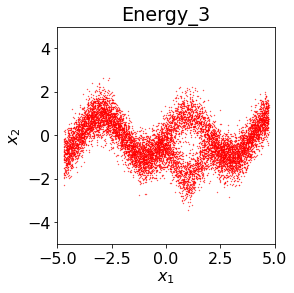

In [120]:
plt.scatter(data[:, 0], data[:, 1], s=0.1, color='red',label='Train')
plt.title(TARGET_DENSITY)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
plt.savefig(f"{images_dir}/jax_NF_plots_{MODEL}_{TARGET_DENSITY}_true_pdf.pdf")

In [111]:


def make_conditioner_nvp(
    event_shape: Sequence[int], hidden_sizes: Sequence[int], num_bijector_params: int
) -> hk.Sequential:

    return hk.Sequential(
        [
            hk.Flatten(preserve_dims=-1),
            hk.nets.MLP(hidden_sizes, activate_final=True),
            hk.Linear(
                num_bijector_params,
                w_init=jnp.zeros,
                b_init=jnp.zeros,
            ),
            hk.Reshape((num_bijector_params,), preserve_dims=-1),
        ]
    )


def make_flow_model_nvp(
    event_shape: Sequence[int],
    num_layers: int,
    hidden_sizes: Sequence[int],
) -> distrax.Transformed:

    mask = jnp.arange(0, np.prod(event_shape)) % 2  # every second element is masked
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    def bijector_fn(params: Array):
        shift, log_scale = jnp.split(params, 2, axis=-1)
        return distrax.ScalarAffine(shift=shift, log_scale=log_scale)

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner_nvp(
                event_shape=event_shape,
                hidden_sizes=hidden_sizes,
                num_bijector_params=2,
            ),
        )

        layers.append(layer)
        # Flip mask after each layer
        mask = jnp.logical_not(mask)

    flow = distrax.Inverse(distrax.Chain(layers))
    base_distribution = distrax.Independent(
        distrax.Normal(loc=jnp.zeros(event_shape), scale=jnp.ones(event_shape)),
        reinterpreted_batch_ndims=len(event_shape),
    )

    return distrax.Transformed(base_distribution, flow)


@hk.without_apply_rng
@hk.transform
def log_prob_nvp(data: Array) -> Array:

    model = make_flow_model_nvp(
        event_shape=data.shape[-1:],
        num_layers=FLOW_NUM_LAYERS,
        hidden_sizes=[HIDDEN_SIZE] * MLP_NUM_LAYERS,
    )

    return model.log_prob(data)


@hk.without_apply_rng
@hk.transform
def sample_nvp(event_shape: Tuple, prng_key: PRNGKey, num_samples: int):  # type: ignore

    model = make_flow_model_nvp(
        event_shape=event_shape,
        num_layers=FLOW_NUM_LAYERS,
        hidden_sizes=[HIDDEN_SIZE] * MLP_NUM_LAYERS,
    )

    return model.sample(seed=prng_key, sample_shape=(num_samples,))


@jax.jit
def loss_fn_nvp(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:  # type: ignore
    # data = prepare_data(batch, prng_key)
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob_nvp.apply(params, batch))
    return loss


@jax.jit
def eval_fn_nvp(params: hk.Params, batch: Batch) -> Array:
    # data = prepare_data(batch)  # We don't dequantize during evaluation.
    loss = -jnp.mean(log_prob_nvp.apply(params, batch))
    return loss

In [94]:
def make_conditioner_maf2(
    event_shape: Sequence[int], hidden_sizes: Sequence[int], num_bijector_params: int
) -> hk.Sequential:

    return hk.Sequential(
        [
            hk.Flatten(preserve_dims=-1),
            hk.nets.MLP(hidden_sizes, activate_final=True),
            hk.Linear(
                np.prod(event_shape) * num_bijector_params,
                w_init=jnp.zeros,
                b_init=jnp.zeros,
            ),
            hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
        ]
    )


def make_flow_model_maf2(
    event_shape: Sequence[int],
    num_layers: int,
    hidden_sizes: Sequence[int],
    flow_num_params: int,
) -> distrax.Transformed:

    mask = jnp.arange(0, np.prod(event_shape)) % 2  # every second element is masked
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    flow_num_params = 3 * flow_num_params + 1

    def bijector_fn(params: Array):
        return distrax.RationalQuadraticSpline(params, range_min=-8.0, range_max=8.0)

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner_maf(
                event_shape=event_shape,
                hidden_sizes=hidden_sizes,
                num_bijector_params=flow_num_params,
            ),
        )

        layers.append(layer)
        # Flip mask after each layer
        mask = jnp.logical_not(mask)

    flow = distrax.Inverse(distrax.Chain(layers))
    base_distribution = distrax.Independent(
        distrax.Normal(loc=jnp.zeros(event_shape), scale=jnp.ones(event_shape)),
        reinterpreted_batch_ndims=len(event_shape),
    )

    return distrax.Transformed(base_distribution, flow)


@hk.without_apply_rng
@hk.transform
def log_prob_maf(data: Array) -> Array:

    model = make_flow_model_maf(
        event_shape=data.shape[-1:],
        num_layers=FLOW_NUM_LAYERS,
        hidden_sizes=[HIDDEN_SIZE] * MLP_NUM_LAYERS,
        flow_num_params=FLOW_NUM_PARAMS,  # num_bins
    )

    return model.log_prob(data)


@hk.without_apply_rng
@hk.transform
def sample_maf(event_shape: Tuple, prng_key: PRNGKey, num_samples: int):  # type: ignore

    model = make_flow_model_maf(
        event_shape=event_shape,
        num_layers=FLOW_NUM_LAYERS,
        hidden_sizes=[HIDDEN_SIZE] * MLP_NUM_LAYERS,
        flow_num_params=FLOW_NUM_PARAMS,  # num_bins
    )

    return model.sample(seed=prng_key, sample_shape=(num_samples,))


@jax.jit
def loss_fn_maf(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:  # type: ignore
    # data = prepare_data(batch, prng_key)
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob_maf.apply(params, batch))
    return loss


@jax.jit
def eval_fn_maf(params: hk.Params, batch: Batch) -> Array:
    # data = prepare_data(batch)  # We don't dequantize during evaluation.
    loss = -jnp.mean(log_prob_maf.apply(params, batch))
    return loss


In [95]:
def make_conditioner_maf(
    event_shape: Sequence[int], hidden_sizes: Sequence[int], num_bijector_params: int
) -> hk.Sequential:

    return hk.Sequential(
        [
            hk.Flatten(preserve_dims=-1),
            hk.nets.MLP(hidden_sizes, activate_final=True),
            hk.Linear(
                np.prod(event_shape) * num_bijector_params,
                w_init=jnp.zeros,
                b_init=jnp.zeros,
            ),
            hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
        ]
    )


def make_flow_model_maf(
    event_shape: Sequence[int],
    num_layers: int,
    hidden_sizes: Sequence[int],
    flow_num_params: int,
) -> distrax.Transformed:

    mask = jnp.arange(0, np.prod(event_shape)) % 2  # every second element is masked
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    flow_num_params = 3 * flow_num_params + 1

    def bijector_fn(params: Array):
        return distrax.RationalQuadraticSpline(params, range_min=-8.0, range_max=8.0)

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            conditioner=make_conditioner_maf(
                event_shape=event_shape,
                hidden_sizes=hidden_sizes,
                num_bijector_params=flow_num_params,
            ),
        )

        layers.append(layer)
        # Flip mask after each layer
        mask = jnp.logical_not(mask)

    flow = distrax.Inverse(distrax.Chain(layers))
    base_distribution = distrax.Independent(
        distrax.Normal(loc=jnp.zeros(event_shape), scale=jnp.ones(event_shape)),
        reinterpreted_batch_ndims=len(event_shape),
    )

    return distrax.Transformed(base_distribution, flow)


@hk.without_apply_rng
@hk.transform
def log_prob_maf(data: Array) -> Array:

    model = make_flow_model_maf(
        event_shape=data.shape[-1:],
        num_layers=FLOW_NUM_LAYERS,
        hidden_sizes=[HIDDEN_SIZE] * MLP_NUM_LAYERS,
        flow_num_params=FLOW_NUM_PARAMS,  # num_bins
    )

    return model.log_prob(data)


@hk.without_apply_rng
@hk.transform
def sample_maf(event_shape: Tuple, prng_key: PRNGKey, num_samples: int):  # type: ignore

    model = make_flow_model_maf(
        event_shape=event_shape,
        num_layers=FLOW_NUM_LAYERS,
        hidden_sizes=[HIDDEN_SIZE] * MLP_NUM_LAYERS,
        flow_num_params=FLOW_NUM_PARAMS,  # num_bins
    )

    return model.sample(seed=prng_key, sample_shape=(num_samples,))


@jax.jit
def loss_fn_maf(params: hk.Params, prng_key: PRNGKey, batch: Batch) -> Array:  # type: ignore
    # data = prepare_data(batch, prng_key)
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob_maf.apply(params, batch))
    return loss


@jax.jit
def eval_fn_maf(params: hk.Params, batch: Batch) -> Array:
    # data = prepare_data(batch)  # We don't dequantize during evaluation.
    loss = -jnp.mean(log_prob_maf.apply(params, batch))
    return loss


In [121]:
if MODEL == 'NVP':
  log_prob = log_prob_nvp
  sample  = sample_nvp
  loss_fn = loss_fn_nvp
  eval_fn = eval_fn_nvp
elif MODEL == 'MAF':
  log_prob = log_prob_maf
  sample  = sample_maf
  loss_fn = loss_fn_maf
  eval_fn = eval_fn_maf


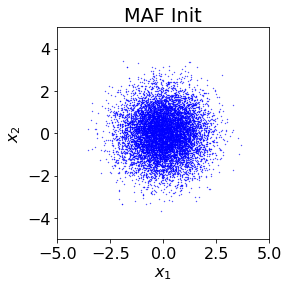

In [122]:


N = 10000
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(next(prng_seq), np.zeros((1, 2)))

samples = sample.apply(
        params=params,
        prng_key=next(prng_seq),
        event_shape=(2,),
        num_samples=N,
)
# make plots
plot_range = np.array([xlim,ylim])
figsize = (8, 8)
plt.scatter(samples[:, 0], samples[:, 1], s=0.1, color='blue',label='Init Train')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.title(f"{MODEL} Init")
plt.savefig(f"{images_dir}/jax_NF_plots_{MODEL}_{TARGET_DENSITY}_init_pdf.pdf")

In [123]:
from IPython.lib.display import IFrame
def train(
    batch_size,
    learning_rate,
    training_steps,
    eval_frequency,
):
    schedule_fn = optax.polynomial_schedule(
    init_value=learning_rate, end_value=learning_rate/10., power=0.5, transition_steps=training_steps)
    optimizer = optax.adam(schedule_fn)

    @jax.jit
    def update(
        params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch
    ) -> Tuple[hk.Params, OptState]:

        """Single SGD update step."""
        grads = jax.grad(loss_fn)(params, prng_key, batch)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state

    prng_seq = hk.PRNGSequence(42)
    params = log_prob.init(next(prng_seq), np.zeros((1, 2)))
    opt_state = optimizer.init(params)

    train_ds = make_dataset(
        seed=2123, batch_size=batch_size, num_batches=2 * training_steps
    )
    valid_ds = make_dataset(
        seed=2235, batch_size=batch_size, num_batches=training_steps
    )

    best_params = params
    best_val_loss = jnp.inf
    all_train_loss = []
    all_val_loss = []

    for step in range(training_steps):
        params, opt_state = update(params, next(prng_seq), opt_state, next(train_ds))

        train_loss = eval_fn(params, next(train_ds))
        val_loss = eval_fn(params, next(valid_ds))
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_params = params

        if step % eval_frequency == 0:
            print(
                f"STEP: {step}; training loss: {train_loss}, validation loss: {val_loss}"
            )
    return best_params, all_train_loss, all_val_loss

In [ ]:

params_fit, train_losses, val_losses  = train(batch_size=128,
    learning_rate=1e-3,
    training_steps=2000,
    eval_frequency=100,
)

STEP: 0; training loss: 6.129143714904785, validation loss: 6.598073959350586
STEP: 100; training loss: 3.211529016494751, validation loss: 3.241471767425537
STEP: 200; training loss: 3.2524282932281494, validation loss: 3.0971198081970215
STEP: 300; training loss: 3.056882858276367, validation loss: 3.2895357608795166
STEP: 400; training loss: 3.186110258102417, validation loss: 3.1471829414367676
STEP: 500; training loss: 3.151042938232422, validation loss: 3.104595184326172
STEP: 600; training loss: 3.1630945205688477, validation loss: 3.0818023681640625
STEP: 700; training loss: 3.1536760330200195, validation loss: 3.108957290649414


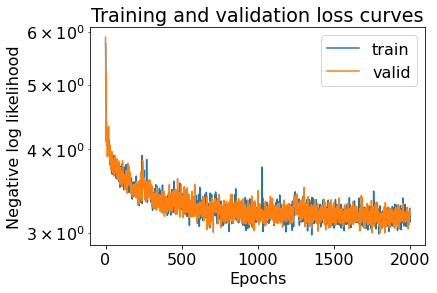

In [116]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='valid')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Negative log likelihood')
plt.title('Training and validation loss curves')
plt.yscale("log")
plt.show()

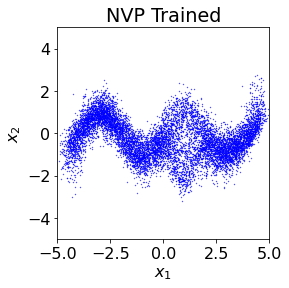

In [117]:
samples = sample.apply(
        params=params_fit,
        prng_key=next(prng_seq),
        event_shape=(2,),
        num_samples=N,
)
# make plots
plot_range = np.array([xlim,ylim])
figsize = (8, 8)
#ax.hist2d(samples[:, 0], samples[:, 1], bins=100, range=plot_range)
plt.scatter(samples[:, 0], samples[:, 1], s=0.1, color='blue',label='Init Train')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.title(f"{MODEL} Trained")
plt.savefig(f"{images_dir}/jax_NF_plots_{MODEL}_{TARGET_DENSITY}_after_train_pdf.pdf")

In [ ]:
    # Evaluate
    #plt.savefig(f"./plots/{density}/real_nvp_{density}.jpg", dpi=750)

    # num_points = 2000
    # x1 = jnp.linspace(-4, 4, num_points)
    # x2 = jnp.linspace(-4, 4, num_points)
    # X1, X2 = jnp.meshgrid(x1, x2)

    # # pdf values of true and learned distribution
    # X1X2 = jnp.stack([X1, X2], axis=-1)
    # Z1 = dataset_pdf(X1X2)
    # Z2 = jnp.exp(log_prob.apply(params, X1X2))

    # fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    # # axes[0].contourf(X1, X2, Z1, cmap="viridis")
    # axes[1].contourf(X1, X2, Z2, cmap="viridis")
    # plt.savefig(f"plots/{DENSITY}/{DENSITY}_pdf.jpg", dpi=600)
